In [3]:

try:
    if  __IPYTHON____IPYTH :
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic(u'load_ext autoreload')
        get_ipython().magic(u'autoreload 2')
except NameError:       
    print('Not IPYTHON')    
    pass

import sys
import numpy as np
from time import time
from scipy.sparse import coo_matrix
import psutil
import glob
import os
import scipy
from ipyparallel import Client
import pylab as pl
import caiman as cm
from caiman.components_evaluation import evaluate_components
from caiman.utils.visualization import plot_contours,view_patches_bar,nb_plot_contour,nb_view_patches
from caiman.base.rois import extract_binary_masks_blob
import caiman.source_extraction.cnmf as cnmf


Not IPYTHON


In [4]:

#import bokeh.plotting as bp#import 
import bokeh.plotting as bpl
try:
       from bokeh.io import vform, hplot
except:
       # newer version of bokeh does not use vform & hplot, instead uses column & row
       from bokeh.layouts import column as vform
       from bokeh.layouts import row as hplot
from bokeh.models import CustomJS, ColumnDataSource, Slider
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.cm as cmap
import numpy as np

bpl.output_notebook()

Loading BokehJS ...

In [24]:
import os
import glob
import numpy as np
import tifffile as tf

In [94]:
# frame rate in Hz
final_frate=10 
#backend='SLURM'
backend='local'
if backend == 'SLURM':
    n_processes = np.int(os.environ.get('SLURM_NPROCS'))
else:
    # roughly number of cores on your machine minus 1
    n_processes = np.maximum(np.int(psutil.cpu_count()),1) 
print('using ' + str(n_processes) + ' processes')
#%% start cluster for efficient computation
single_thread=False

if single_thread:
    dview=None
else:    
    try:
        c.close()
    except:
        print('C was not existing, creating one')
    print("Stopping  cluster to avoid unnencessary use of memory....")
    sys.stdout.flush()  
#     if backend == 'SLURM':
#         try:
#             cm.stop_server(is_slurm=True)
#         except:
#             print('Nothing to stop')
#         slurm_script='/mnt/xfs1/home/agiovann/SOFTWARE/Constrained_NMF/SLURM/slurmStart.sh'
#         cm.start_server(slurm_script=slurm_script)
#         pdir, profile = os.environ['IPPPDIR'], os.environ['IPPPROFILE']
#         c = Client(ipython_dir=pdir, profile=profile)        
#     else:
    cm.stop_server()
    cm.start_server()        
    c=Client()

    print('Using '+ str(len(c)) + ' processes')
    dview=c[:len(c)]

using 8 processes
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
No cluster to stop... done
Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
.....Using 8 processes


In [110]:

c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)
    

In [111]:
print n_processes
print dview

8


### Get TIF source

In [18]:
rootdir = '/mnt/odyssey'
animalid = 'CE077'
session = '20180523'
acquisition = 'FOV1_zoom1x'

acquisition_dir = os.path.join(rootdir, animalid, session, acquisition)

tif_src_dir = os.path.join(acquisition_dir, 'caiman_test_data')
fnames = glob.glob(os.path.join(tif_src_dir, '*.tif'))
print "Found %i tifs in src: %s" % (len(fnames), tif_src_dir)

Found 4 tifs in src: /mnt/odyssey/CE077/20180523/FOV1_zoom1x/caiman_test_data


In [91]:
# Set output dir for figures and results:
output_dir = os.path.join(tif_src_dir, 'results')
fig_dir = os.path.join(output_dir, 'figures')
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
    

### Create memmapped files:

In [27]:
# Determind min value of dataset:
add_to_movie = np.max([-np.min(tf.imread(fname, pages=[5])) for fname in fnames])
print add_to_movie

1971


In [28]:
# Params for mmap:
downsampe_factor = 1
border_to_0 = 2
base_name = 'Yr'

In [29]:
# downsample_factor=1 # use .2 or .1 if file is large and you want a quick answer
# #final_frate=final_frate*downsample_factor

# name_new=cm.save_memmap_each(fnames
#         , dview=dview, base_name=base_name, resize_fact=(1, 1, downsample_factor)
#         , remove_init=0, idx_xy=None, border_to_0=border_to_0 )
# name_new.sort()

CompositeError: one or more exceptions from call to method: save_place_holder
[3:apply]: MemoryError: 

In [33]:
# Run on cluster, rename (memory...)
name_new = glob.glob(os.path.join(acquisition_dir, 'caiman_test_data', 'memmap', '*.mmap'))
print name_new

for ni, n in enumerate(name_new):
    mdir = os.path.split(n)[0]
    mfile = '%s%s' % ('gratings_%i' % int(ni+1000), os.path.split(n)[1].split('File%03d' % int(ni+1))[-1])
    print(mfile)
    os.rename(n, os.path.join(mdir, mfile))


['/mnt/odyssey/CE077/20180523/FOV1_zoom1x/caiman_test_data/memmap/FOV1_zoom1x_blobs_Slice01_Channel01_File005_Yr_d1_512_d2_512_d3_1_order_F_frames_2860_.mmap', '/mnt/odyssey/CE077/20180523/FOV1_zoom1x/caiman_test_data/memmap/FOV1_zoom1x_blobs_Slice01_Channel01_File006_Yr_d1_512_d2_512_d3_1_order_F_frames_2860_.mmap', '/mnt/odyssey/CE077/20180523/FOV1_zoom1x/caiman_test_data/memmap/FOV1_zoom1x_blobs_Slice01_Channel01_File007_Yr_d1_512_d2_512_d3_1_order_F_frames_2860_.mmap', '/mnt/odyssey/CE077/20180523/FOV1_zoom1x/caiman_test_data/memmap/FOV1_zoom1x_blobs_Slice01_Channel01_File008_Yr_d1_512_d2_512_d3_1_order_F_frames_2860_.mmap']
gratings_1000FOV1_zoom1x_blobs_Slice01_Channel01_File005_Yr_d1_512_d2_512_d3_1_order_F_frames_2860_.mmap
gratings_1001FOV1_zoom1x_blobs_Slice01_Channel01_File006_Yr_d1_512_d2_512_d3_1_order_F_frames_2860_.mmap
gratings_1002FOV1_zoom1x_blobs_Slice01_Channel01_File007_Yr_d1_512_d2_512_d3_1_order_F_frames_2860_.mmap
gratings_1003FOV1_zoom1x_blobs_Slice01_Channel01

In [34]:
##%% Join into one giant mmap if needed
name_new = glob.glob(os.path.join(acquisition_dir, 'caiman_test_data', 'memmap', '*.mmap'))
if len(name_new) > 1:
    fname_new = cm.save_memmap_join(
        name_new, base_name='Yr', n_chunks=20, dview=dview)
else:
    print('One file only, not saving!')
    fname_new = name_new[0]


('/mnt/odyssey/CE077/20180523/FOV1_zoom1x/caiman_test_data/memmap/gratings_1000FOV1_zoom1x_blobs_Slice01_Channel01_File005_Yr_d1_512_d2_512_d3_1_order_F_frames_2860_.mmap', 2860)
('/mnt/odyssey/CE077/20180523/FOV1_zoom1x/caiman_test_data/memmap/gratings_1001FOV1_zoom1x_blobs_Slice01_Channel01_File006_Yr_d1_512_d2_512_d3_1_order_F_frames_2860_.mmap', 2860)
('/mnt/odyssey/CE077/20180523/FOV1_zoom1x/caiman_test_data/memmap/gratings_1002FOV1_zoom1x_blobs_Slice01_Channel01_File007_Yr_d1_512_d2_512_d3_1_order_F_frames_2860_.mmap', 2860)
('/mnt/odyssey/CE077/20180523/FOV1_zoom1x/caiman_test_data/memmap/gratings_1003FOV1_zoom1x_blobs_Slice01_Channel01_File008_Yr_d1_512_d2_512_d3_1_order_F_frames_2860_.mmap', 2860)
/mnt/odyssey/CE077/20180523/FOV1_zoom1x/caiman_test_data/memmap/Yr_d1_512_d2_512_d3_1_order_C_frames_11440_.mmap
Deleting big mov


In [38]:
fname_new = glob.glob(os.path.join(acquisition_dir, 'caiman_test_data', 'memmap', 'Yr_*'))[0]
print fname_new

/mnt/odyssey/CE077/20180523/FOV1_zoom1x/caiman_test_data/memmap/Yr_d1_512_d2_512_d3_1_order_C_frames_11440_.mmap


### Load memmapped file (all runs):

In [39]:
#% LOAD MEMMAP FILE
Yr, dims, T = cm.load_memmap(fname_new)
d1, d2 = dims
images = np.reshape(Yr.T, [T] + list(dims), order='F')
Y = np.reshape(Yr, dims + (T,), order='F')

number of chunks:0 frames: [0, 1500]
number of chunks:1 frames: [1500, 3000]
number of chunks:2 frames: [3000, 4500]
number of chunks:3 frames: [4500, 6000]
number of chunks:4 frames: [6000, 7500]
number of chunks:5 frames: [7500, 9000]
number of chunks:6 frames: [9000, 11440]


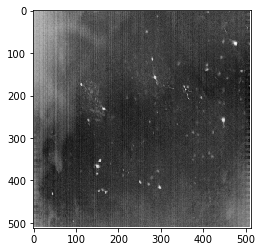

In [40]:
# Look at correlation image:
Cn = cm.movie(images).local_correlations(swap_dim=False) #cm.local_correlations(Y)
#Cn[np.isnan(Cn)] = 0


In [60]:
np.savez(os.path.join(output_dir, 'Cn.npz'), Cn=Cn)


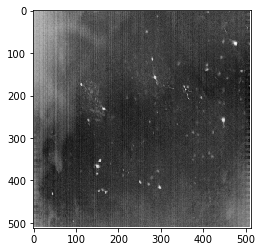

In [71]:
fig, ax = pl.subplots(1)
ax.imshow(Cn, cmap='gray') #, vmax=.35)
fig.savefig(os.path.join(output_dir, 'figures', 'Cn.png'))



# cNMF: Extract from patches:

In [73]:

K=10
gSig=[3, 3]
dview=None
Ain=None
rf=25
stride_cnmf = 6
init_method='greedy_roi'
alpha_snmf=None
final_frate=None
p=2
merge_thresh=0.8

#%% Extract spatial and temporal components on patches
#t1 = time.time()
cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=0.8, p=0, dview=dview, Ain=None, 
                rf=rf, stride=stride_cnmf, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, only_init_patch=True, gnb=1, 
                method_deconvolution='cvxpy')


In [74]:
cnm.options

{'init_params': {'K': 10,
  'alpha_snmf': 1000.0,
  'center_psf': False,
  'deconvolve_options_init': None,
  'gSig': [3, 3],
  'gSiz': [7, 7],
  'kernel': None,
  'maxIter': 5,
  'max_iter_snmf': 500,
  'method': 'greedy_roi',
  'min_corr': 0.85,
  'min_pnr': 20,
  'nIter': 5,
  'nb': 1,
  'normalize_init': True,
  'options_local_NMF': None,
  'perc_baseline_snmf': 20,
  'ring_size_factor': 1.5,
  'rolling_length': 100,
  'rolling_sum': True,
  'sigma_smooth_snmf': (0.5, 0.5, 0.5),
  'ssub': 2,
  'tsub': 2},
 'merging': {'thr': 0.8},
 'patch_params': {'nb': 1,
  'only_init': True,
  'remove_very_bad_comps': False,
  'skip_refinement': False,
  'ssub': 1,
  'tsub': 1},
 'preprocess_params': {'check_nan': True,
  'compute_g': False,
  'include_noise': False,
  'lags': 5,
  'max_num_samples_fft': 3072,
  'n_pixels_per_process': 4000,
  'noise_method': 'mean',
  'noise_range': [0.25, 0.5],
  'p': 0,
  'pixels': None,
  'sn': None},
 'spatial_params': {'dims': (1, 1),
  'dist': 3,
  'extra

In [77]:
cnm.options['spatial_params']['dist'] = 2
cnm.options['spatial_params']['method'] = 'ellipse'
cnm.options['temporal_params']['method'] = 'cvxpy'



In [78]:
# Extract components:
cnm = cnm.fit(images)

# Save because can take awhile, and want to be able to play around with params:
np.savez(os.path.join(output_dir, 'results_analysis.npz'), 
         A_tot=cnm.A, C_tot=cnm.C, YrA_tot=cnm.YrA, b_tot=cnm.b, f_tot=cnm.f, sn_tot=cnm.sn,
        options=cnm.options)


(11440, 512, 512)
using 8 processes
using 4000 pixels per process
using 5000 block_size
(50, 50)
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING RO

(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filteri

(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filteri

(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2549
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filteri

(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filteri

(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filteri

(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2549
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filteri

(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filteri

(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2600
(11440, 51, 51)
using 1 processes
using 625 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5720, 25)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filteri

(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
1999
2499
936.599910975
Transforming patches into full matrix
Skipped %d Empty Patch 0
Generating background
Compressing background components with a low rank NMF
Generating background DONE
merging


/home/juliana/anaconda/envs/pipeline/lib/python2.7/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


[441 442 443 444 445 446 447 448 452 453 455 456 458 566 567 570 571 573]
[500 504 620 621 622 623 624 625 626 627 628 732 740 741 742 743 744 745
 746]
[850 851 852 853 854 855 857 858 970 971 972 973]
[190 191 192 193 194 197 202 205 206 310 311 313]
[381 382 383 384 385 386 387 388 389 392]
[410 411 414 530 531 532 533 645 655]
[430 440 550 561 564]
[ 961  962  965 1080 1081 1082 1083 1085]
[871 872 873 993 994 995 996 997]
[390 393 394 395 398]
[1300 1310 1420 1430]
[220 221 230 232]
[760 880 881 882 891]
[761 762 763 764 767]
[591 592 593 711 712]
[501 502 503]
[690 700 824]
[173 293 294]
[1211 1331 1333]
[930 932 933]
[ 53 170 171]
[1051 1055 1170]
[1122 1133 1135]
[870 991]
[1280 1400]
[580 590]
[462 474]
[460 471]
[331 340]
[1286 1408]
[1271 1394]
[710 831]
[1241 1363]
[380 505]
[1294 1417]
[330 451]
[540 552]
[1207 1325]
[341 351]
[1220 1340]
[1291 1410]
[1210 1330]
[1010 1130]
[1260 1380]
[1250 1372]
[701 713]
[586 596]
[280 284]
[343 356]
[770 892]
[ 910 1033]
[465 477]
[129

In [79]:
##%%
A_tot = cnm.A
C_tot = cnm.C
YrA_tot = cnm.YrA
b_tot = cnm.b
f_tot = cnm.f
sn_tot = cnm.sn
#t2 = time.time() - t1

print(('Number of components:' + str(A_tot.shape[-1])))
#


Number of components:1235


#### Evaluate components:

In [85]:
fr = 44.69             # approximate frame rate of data
decay_time = 5.0    # length of transient
min_SNR = 1.2      # peak SNR for accepted components (if above this, acept)
rval_thr = 0.70     # space correlation threshold (if above this, accept)
use_cnn = False # use the CNN classifier
min_cnn_thr = 0.95  # if cnn classifier predicts below this value, reject
dims = [d1, d2]
gSig = (3, 3)

idx_components, idx_components_bad, SNR_comp, r_values, cnn_preds = \
    cm.components_evaluation.estimate_components_quality_auto(
                                    images, A_tot, C_tot, b_tot, f_tot,
                                     YrA_tot, fr, decay_time, gSig, dims,
                                     dview=dview, min_SNR=min_SNR,
                                     r_values_min=rval_thr, use_cnn=use_cnn,
                                     thresh_cnn_min=min_cnn_thr)

tB:-8.0,tA:38.0
Computing event exceptionality delta
Removing Baseline
binning data ...
interpolating data ...
(15, 50)
Computing event exceptionality
Evaluating spatial footprint
components evaluated:0
tB:-8.0,tA:38.0
Computing event exceptionality delta
Removing Baseline
binning data ...
interpolating data ...
(15, 50)
Computing event exceptionality
Evaluating spatial footprint
components evaluated:0
tB:-8.0,tA:38.0
Computing event exceptionality delta
Removing Baseline
binning data ...
interpolating data ...
(15, 50)
Computing event exceptionality
Evaluating spatial footprint
components evaluated:0
tB:-8.0,tA:38.0
Computing event exceptionality delta
Removing Baseline
binning data ...
interpolating data ...
(15, 50)
Computing event exceptionality
Evaluating spatial footprint
components evaluated:0
tB:-8.0,tA:38.0
Computing event exceptionality delta
Removing Baseline
binning data ...
interpolating data ...
(15, 50)
Computing event exceptionality
Evaluating spatial footprint
componen

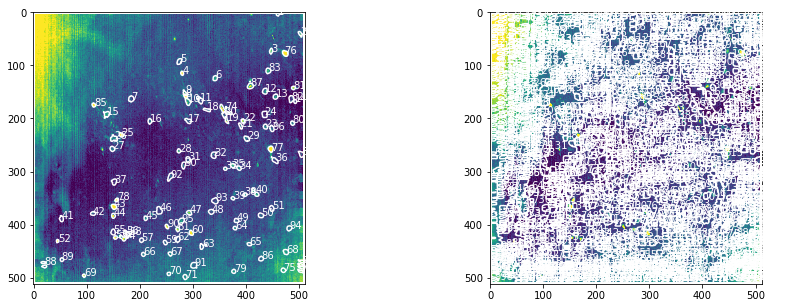

In [86]:
pl.figure(figsize=(15,5))
pl.subplot(1,2,1)
crd = plot_contours(A_tot.tocsc()[:, idx_components], Cn, thr=0.9)
pl.subplot(1,2,2)
crd = plot_contours(A_tot.tocsc()[:, idx_components_bad], Cn, thr=0.9)


In [87]:
print "Keeping %i components." % len(idx_components)

Keeping 96 components.


# Discard really bad comps, and re-run:

In [88]:
A_tot = A_tot.tocsc()[:, idx_components]
C_tot = C_tot[idx_components]


In [112]:
A_tot.shape

(262144, 96)

In [113]:
cnm = cnmf.CNMF(n_processes, k=A_tot.shape[-1], gSig=gSig, merge_thresh=merge_thresh, p=p, dview=dview, Ain=A_tot, Cin=C_tot,
                f_in=f_tot, rf=None, stride=None, method_deconvolution='oasis')
cnm.options['temporal_params']['method'] = 'cvxpy'
print cnm.options


{'spatial_params': {'dist': 3, 'method_ls': 'lasso_lars', 'dims': (1, 1), 'nrgthr': 0.9999, 'n_pixels_per_process': 4000, 'update_background_components': True, 'low_rank_background': True, 'thr_method': 'nrg', 'nb': 1, 'ss': array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8), 'extract_cc': True, 'medw': (3, 3), 'maxthr': 0.1, 'method': 'dilate', 'se': array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)}, 'merging': {'thr': 0.8}, 'temporal_params': {'verbosity': False, 'memory_efficient': False, 'solvers': ['ECOS', 'SCS'], 'method': 'cvxpy', 'block_size': None, 'noise_range': [0.25, 0.5], 'fudge_factor': 0.96, 'noise_method': 'mean', 'nb': 1, 'ITER': 2, 'lags': 5, 'p': 2, 'bas_nonneg': False}, 'preprocess_params': {'check_nan': True, 'compute_g': False, 'pixels': None, 'noise_range': [0.25, 0.5], 'n_pixels_per_process': 4000, 'noise_method': 'mean', 'max_num_samples_fft': 3072, 'lags': 5, 'p': 2, 'include_noise': False, 'sn': None}, 'init_params': {'kern

In [114]:
cnm = cnm.fit(images)

(11440, 512, 512)
using 8 processes
using 4000 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data


TypeError: 'str' object is not callable

#### Visualize refined run:

In [ ]:
pl.figure()
crd = plot_contours(A, Cn, thr=0.9)


#### Evaluate refined run:

In [ ]:
fr = 44.7             # approximate frame rate of data
decay_time = 5.0    # length of transient
min_SNR = 1.5      # peak SNR for accepted components (if above this, acept)
rval_thr = 0.90     # space correlation threshold (if above this, accept)
use_cnn = False # use the CNN classifier
min_cnn_thr = 0.95  # if cnn classifier predicts below this value, reject
dims = [d1, d2]
gSig = (4, 4)

idx_components, idx_components_bad, SNR_comp, r_values, cnn_preds = \
    cm.components_evaluation.estimate_components_quality_auto(
                                    images, A_tot, C_tot, b_tot, f_tot,
                                     YrA_tot, fr, decay_time, gSig, dims,
                                     dview=dview, min_SNR=min_SNR,
                                     r_values_min=rval_thr, use_cnn=use_cnn,
                                     thresh_cnn_min=min_cnn_thr)

#### Visualize "good" components:

In [ ]:
crd = plot_contours(A[:, idx_components], Cn, thr=0.9)


In [ ]:
cm.utils.visualization.view_patches_bar(Yr, A[:, idx_components],
                                        C[idx_components, :], b, f,
                                        d1, d2,
                                        YrA=YrA[idx_components, :], img=img)



In [ ]:
#traces = C_tot + YrA_tot

# Look at EACH step

## cNMF:  Preprocessing

In [ ]:
Yr,sn,g,psx = cnmf.pre_processing.preprocess_data(Yr
            ,dview=dview
            ,n_pixels_per_process=100,  noise_range = [0.25,0.5]
            ,noise_method = 'logmexp', compute_g=False,  p = 2,
             lags = 5, include_noise = False, pixels = None
            ,max_num_samples_fft=3000, check_nan = True)


# cNMF: Initialize components

In [ ]:
Ain, Cin, b_in, f_in, center=cnmf.initialization.initialize_components(Y
            ,K=K, gSig=gSig, gSiz=None, ssub=1, tsub=1, nIter=5, maxIter=5, nb=1
            , use_hals=False, normalize_init=True, img=None, method='greedy_roi'
            , max_iter_snmf=500, alpha_snmf=10e2, sigma_smooth_snmf=(.5, .5, .5)
            , perc_baseline_snmf=20)

p1=nb_plot_contour(Cn,Ain,dims[0],dims[1],thr=0.9,face_color=None,
                   line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

In [ ]:
### initialize w/ HALS:

AinAin,,  CinCin,,  b_inb_in,,  f_inf_in  ==  cnmfcnmf.initializationinitial.hals(Y, Ain, Cin, b_in, f_in, maxIter=5)
p1=nb_plot_contour(Cn,Ain,dims[0],dims[1],thr=0.9,face_color=None,
                   line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)